# ---- ecco

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')
import sys
sys.path.append('/linkhome/rech/genlop01/uor98hu/ECCOv4-py/ECCOv4-py-master/')
import ecco_v4_py as ecco

In [2]:
# standart librairies
# plot
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import ticker
import cmocean as ccm

from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
import multiprocessing.popen_spawn_posix
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:38813 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 10 Memory: 20.97 GB


In [4]:
PATH="/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/ECCO/ssh_data/"

In [5]:
GRID=xr.open_dataset(PATH+"ECCO-GRID.nc")

In [6]:
chunk_size = {'tile':1}
SSH=xr.open_mfdataset(PATH+"SSH/*/*nc",chunks=chunk_size, parallel=True).SSH

In [7]:
# faire la moyenne annuelle
slats_ECCO2plot_1y = SSH.groupby('time.year').mean('time') #1992 to 2017;  

# enlever le GMSL
GMSL_ECCO_NASA  = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/ECCO/GLOBAL_MEAN_SEA_LEVEL_mon_mean_ECCO_V4r4_1D.nc").global_mean_sea_level_anomaly
GMSL_ECCO_NASA_1y = GMSL_ECCO_NASA.groupby('time.year').mean('time')
slats_ECCO2plot_1y_corr= slats_ECCO2plot_1y - GMSL_ECCO_NASA_1y

# enlever la time mean
slats_ECCO2plot_1y_corrshif = slats_ECCO2plot_1y_corr - slats_ECCO2plot_1y_corr.mean('year')

# compute la std en cm
ecco_std = slats_ECCO2plot_1y_corrshif.std('year')*100


In [8]:
ecco_std_computed = ecco_std.compute()

In [9]:
matrix1 = ecco_std.copy(data=np.ones((13,90,90)))

In [10]:
maskBGR = matrix1.where((GRID.XC<-130) & (GRID.XC>-170) & (GRID.YC<81) & (GRID.YC>70)& (GRID.Depth>300),0)

In [23]:
# fig = plt.figure(figsize=(10,10), dpi= 72*2)
# # fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2)

# tmp_plt = maskBGR #SSH_weighted.isel(time=1)
# tmp_plt = tmp_plt.where(GRID.hFacC.isel(k=0) !=0)

# cs = ecco.plot_proj_to_latlon_grid(GRID.XC, GRID.YC, \
#                               tmp_plt, \
#                               projection_type='stereo',\
#                               plot_type = 'contourf', \
#                               show_colorbar=True,\
#                               #dx=1, dy=1,
#                               lat_lim=60,
#                              cmax=10, cmin=0); #cmin=-1, cmax=1,


# # il existe resample_to_latlon to convert to any grid. 

# interpolating to a new grid

In [17]:
new_grid_delta_lat = 0.1
new_grid_delta_lon = 0.1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
std_0_25 =\
        ecco.resample_to_latlon(GRID.XC, \
                                GRID.YC, \
                                ecco_std_computed,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)


masknew_grid_lon_centers, masknew_grid_lat_centers,\
masknew_grid_lon_edges, masknew_grid_lat_edges,\
mask_0_25 =\
        ecco.resample_to_latlon(GRID.XC, \
                                GRID.YC, \
                                maskBGR,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

In [18]:
#dimension of the new grid
print(new_grid_lat_centers.shape)
print(new_grid_lon_centers.shape)

(1800, 3600)
(1800, 3600)


In [19]:
da_std = xr.DataArray(std_0_25)

In [22]:
# (da_std.where(da_std!=0,np.nan)).values

In [15]:
# default gridlines parameters
gridl=False
incrgridlon=30
incrgridlat=10

# vue N.Atl
# loncentr=330 # before it was zero
# latcentr=70

#vue polaire
loncentr=200 # before it was zero
latcentr=90

sath=2085831

# #========= Plot settings ===============
# # colormap
# def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
#     new_cmap = mcolors.LinearSegmentedColormap.from_list(
#         'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
#         cmap(np.linspace(minval, maxval, n)))
#     return new_cmap

# cmap1 = cm.RdYlBu_r
# my_map1 = truncate_colormap(cmap1)
# colors1 = my_map1(np.linspace(0., 1, 50))
# mycm1 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors1)

# lmin = -20.0
# incr = 1
# lmax = lmin*(-1)+0.1
# # define the bins and normalize
# bounds1 = np.arange(lmin,lmax,incr)

# norm1 = mcolors.BoundaryNorm(bounds1, mycm1.N)

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


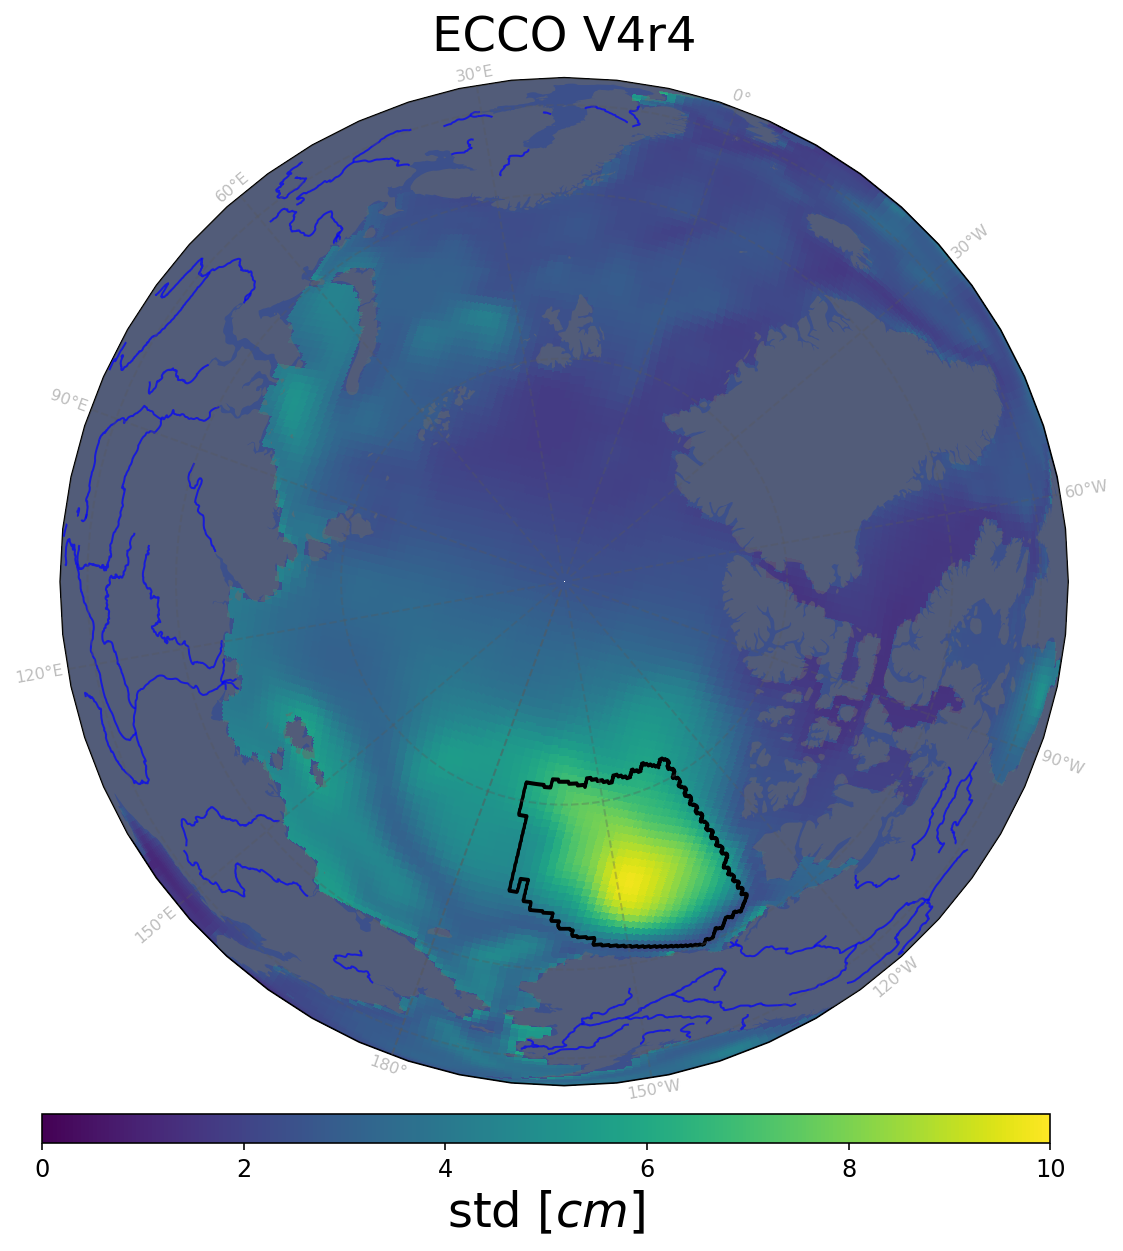

In [20]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})

#----------------- SLA part--------------------------------------
# ========GAI
data2plot = (da_std.where(da_std!=0,np.nan)).squeeze()
axa.contour(masknew_grid_lon_centers,masknew_grid_lat_centers,mask_0_25,1,colors="k",transform=trdata)
cs  = axa.pcolormesh(new_grid_lon_centers,new_grid_lat_centers, data2plot,shading='flat',transform=trdata, vmax=10, vmin=0) #,norm=norm_SLA)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=.5,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

axa.set_title("ECCO V4r4", fontsize=24) 

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal') #extend='max'
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'std [$cm$]', fontsize=24)
## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

namo="maps_signi010_SLA_GAI_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)

# compute the trend of ECCO 

In [24]:
import esmtools

In [25]:
# compute the trend
ECCO_computed = slats_ECCO2plot_1y_corrshif.compute()


In [26]:
lin_ecco = esmtools.stats.linregress((ECCO_computed.sel(year=slice("2005","2017"))*1000), dim="year") # pour avoir en mm/yr

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/esmtools/stats.py:394: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  results = xr.apply_ufunc(


In [27]:
# significance threshold
pval = 0.10
alphaHatch = 0.05

In [36]:
def vectorize(cs):
    """
    Vectorize contourf plots to reduce weight of figures saved as PDFs.
    """
    for c in cs.collections:
        c.set_rasterized(True)
        
# default gridlines parameters
gridl=False
incrgridlon=30
incrgridlat=10

# vue N.Atl
# loncentr=330 # before it was zero
# latcentr=70

#vue polaire
loncentr=200 # before it was zero
latcentr=90

sath=2085831

#========= Plot settings ===============
# colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap1 = cm.RdYlBu_r
my_map1 = truncate_colormap(cmap1)
colors1 = my_map1(np.linspace(0., 1, 50))
mycm1 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors1)

lmin = -20.0
incr = 1
lmax = lmin*(-1)+0.1
# define the bins and normalize
bounds1 = np.arange(lmin,lmax,incr)

norm1 = mcolors.BoundaryNorm(bounds1, mycm1.N)

In [30]:
# p-value
gai_pval  = lin_ecco.sel(parameter='pvalue')
# slope
gai_trend = lin_ecco.sel(parameter='slope')

gai_signi = matrix1.where(gai_pval > pval)


In [33]:
#interpolate
new_grid_delta_lat = 0.1
new_grid_delta_lon = 0.1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
trend_interp =\
        ecco.resample_to_latlon(GRID.XC, \
                                GRID.YC, \
                                gai_trend,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

new_grid_lon_centers2, new_grid_lat_centers2,\
new_grid_lon_edges2, new_grid_lat_edges2,\
gai_signi_interp =\
        ecco.resample_to_latlon(GRID.XC, \
                                GRID.YC, \
                                gai_signi,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

In [38]:
da_trend = xr.DataArray(trend_interp)
da_signi = xr.DataArray(gai_signi_interp)

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


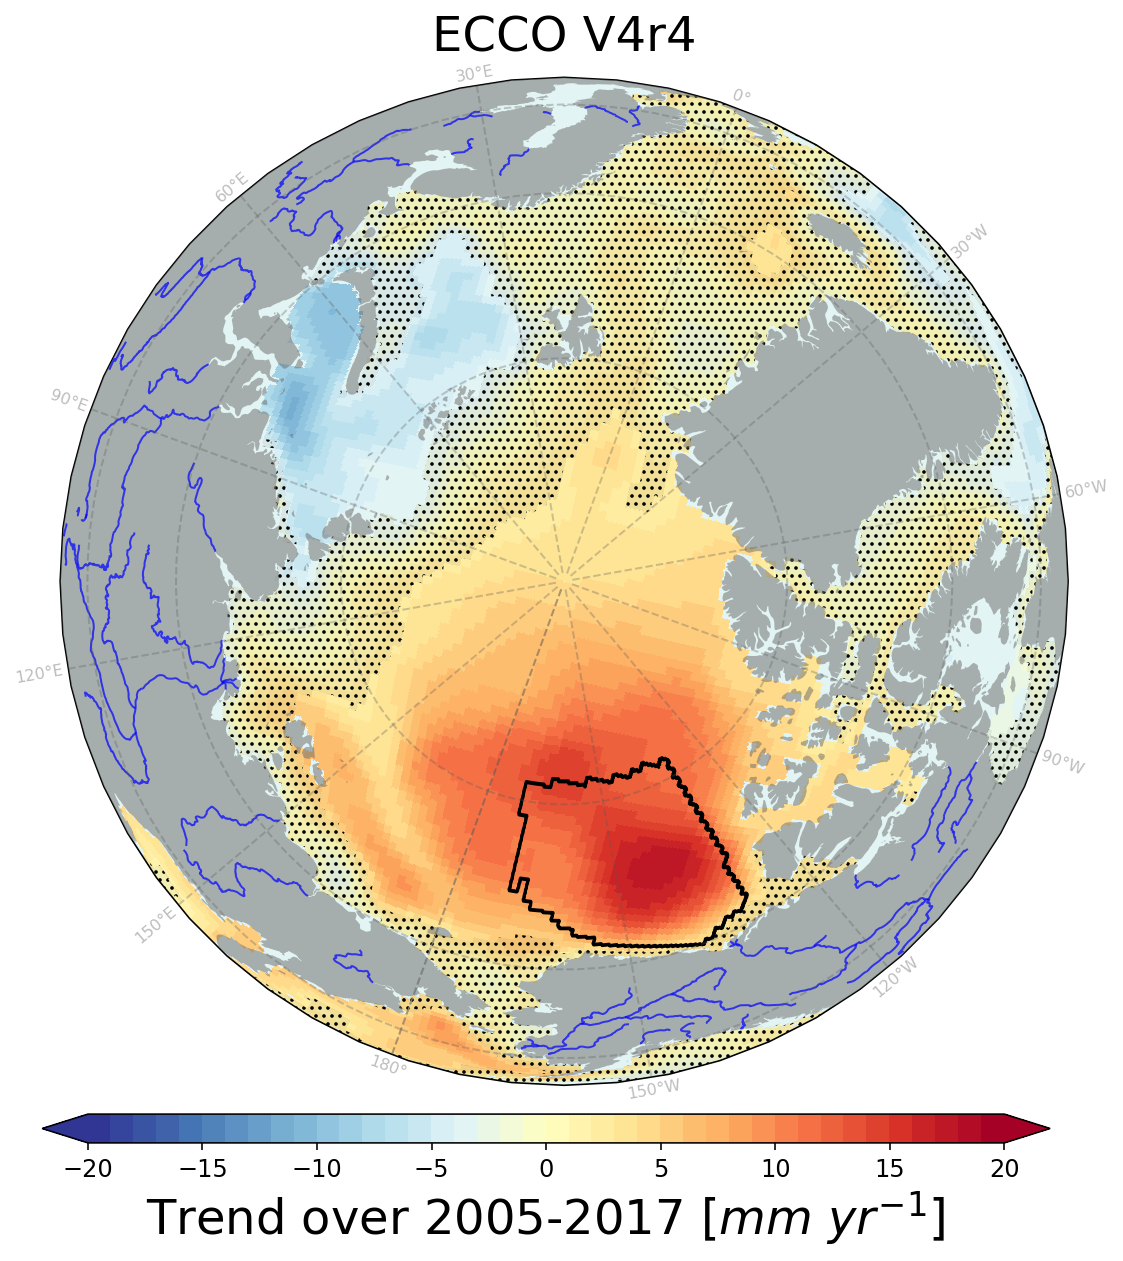

tornado.application - ERROR - Uncaught exception GET /status/ws (::1)
HTTPServerRequest(protocol='http', host='jupyterhub.idris.fr', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/tornado/web.py", line 3173, in wrapper
    return method(self, *args, **kwargs)
  File "/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/bokeh/server/views/ws.py", line 137, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


In [40]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})

data2plot = (da_trend).squeeze()
cs  = axa.pcolormesh(new_grid_lon_centers,new_grid_lat_centers, data2plot,shading='flat',transform=trdata, cmap = mycm1,norm=norm1)

cs2_2= axa.contourf(new_grid_lon_centers,new_grid_lat_centers, da_signi.where(da_signi==1),transform=trdata, \
                    colors='none',alpha=alphaHatch,hatches=['...'*1, '/']) # j'ai enlevé le .where(nav_lon>0)
vectorize(cs2_2)

# cs2_1= axa.contourf(nav_lon,nav_lat,gai_signi.where(gai_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=alphaHatch,hatches=['...'*1, '/'])
# vectorize(cs2_1)
axa.contour(masknew_grid_lon_centers,masknew_grid_lat_centers,mask_0_25,1,colors="k",transform=trdata)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=.5,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

axa.set_title("ECCO V4r4", fontsize=24) 

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
cbar = fig.colorbar(cs,extend='both', cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)

cbar.set_label(r'Trend over 2005-2017 [$mm$ $yr^{-1}$]', fontsize=24)
## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

# namo="maps_signi010_SLA_GAI_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)

In [29]:

# fig = plt.figure(figsize=(10,10), dpi= 72*2)
# # fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2)

# tmp_plt = lin_ecco.sel(parameter='slope') #SSH_weighted.isel(time=1)
# tmp_plt = tmp_plt.where(GRID.hFacC.isel(k=0) !=0)

# cs = ecco.plot_proj_to_latlon_grid(GRID.XC, GRID.YC, \
#                               tmp_plt, \
#                               projection_type='stereo',\
#                               plot_type = 'contourf', \
#                               show_colorbar=True,\
#                               # dx=1, dy=1,\
#                               lat_lim=60,\
#                             cmap = cm.RdYlBu_r,
#                              cmax=20, cmin=-20); #cmin=-1, cmax=1,


# # il existe resample_to_latlon to convert to any grid. 

## compute the ts of ssh in the BGR

In [ ]:
# # constructing the BGR mask weight
# cellArea_masked = (GRID.rA * GRID.hFacC.isel(k=0)).where((GRID.XC<-130) & (GRID.XC>-170) & (GRID.YC<81) & (GRID.YC>70)& (GRID.Depth>300),0)
# cellAreamasktot = cellArea_masked.sum(('i','j'))
# cellAreaweight = cellArea_masked / cellAreamasktot

# # masking SSH and applying the weight
# SSH_masked = SSHcorr.where((GRID.XC<-130) & (GRID.XC>-170) & (GRID.YC<81) & (GRID.YC>70)& (GRID.Depth>300),0)

# SSH_weighted = SSH_masked*cellAreaweight

# # compute the ssh in the BGR box
# SSH_weighted_ts = SSH_weighted.sum(('j','i')).isel(tile=6)

# # saving the time series
# ds = xr.Dataset(
#             data_vars=dict(ssh_ecco_ts=(["time_counter"], SSH_weighted_ts.data)),
#             coords=dict(time_counter=(["time_counter"], SSH_weighted_ts.time.values))
#                 )
            
# ds.to_netcdf('/home1/datawork/stajouri/IMHOTEP/VALIDATION/BGRmask_sshcorrGMSL_ecco_ts.nc', mode='w')
 

In [65]:
help(ecco.plot_proj_to_latlon_grid)

Help on function plot_proj_to_latlon_grid in module ecco_v4_py.tile_plot_proj:

plot_proj_to_latlon_grid(lons, lats, data, projection_type='robin', dx=0.25, dy=0.25, mapping_method='nearest_neighbor', radius_of_influence=112000, plot_type='pcolormesh', circle_boundary=False, cmap=None, cmin=None, cmax=None, user_lon_0=0, user_lat_0=None, lat_lim=50, parallels=None, show_coastline=True, show_colorbar=False, show_land=True, show_grid_lines=True, show_grid_labels=False, show_coastline_over_data=True, show_land_over_data=True, grid_linewidth=1, grid_linestyle='--', colorbar_label=None, subplot_grid=None, less_output=True, **kwargs)
    Plot a field of data from an arbitrary projection with lat/lon coordinates
    on a geographic projection after resampling it to a regular lat/lon grid.
    
    
    Parameters
    ----------
    lons, lats : numpy ndarray or xarray DataArrays, required
        the longitudes and latitudes of the data to plot
        
    data : numpy ndarray or xarray Data